In [1]:
%%capture
import sales_models as sm
X = sm.PriorsPlayML(11)

# Introduction

In this Play-ML notebook we are going to explore the concept of **uncertainty quantification**. We will explore UQ in the context of recommending a price to set for a product. One very important reason that decisions are difficult to take is because of uncertainty: how can we be sure that *this* is the right thing to do and not *that*? And, just as importantly, what's the risk of getting things wrong? 

So let's illustrate uncertainty quantification in the context of price recommendations. Suppose we own a website that sells exactly one kind of product&mdash;a deluxe mud kitchen, say&mdash;and that any customer will only buy at most one. Indeed, you really only need one mud kitchen, *deluxe* or otherwise. In this notebook we will think about a simple model for how sales of our mud kitchen depend on the price we set, and use that model to try to recommend a good price.

## A toy model

<img align="right" width="350" src="./mudkitchen.jpg">

The model is described by three parameters. There is an **arrival rate**, at which potential customers stumble across our site. For simplicity we assume that the price of our mud kitchen is not marketed nor scraped from our website: the arrival rate is fixed at a number of customers per day and doesn't vary with price.

Where price does enter the picture is in the conversion rate: the probability that any one customer on our website will make a (single) purchase. This is assumed to be very much price dependent: when the price is low, this probability very high, but as the price increases the probability of a purchase will decrease to zero. We model this behaviour with a logistic curve, which gives two degrees of freedom to set. The first of these is the **reference price**, which can be defined as the price at which the probability of a customer making a purchase is 50%. The second parameter characterising the price response is the **reference elasticity**. This parameter, denoted by $E$, is interpreted as a measure of price sensitivity: if the price is at a 1% premium on the reference price, then demand will increase by $E$%. Of course, we would expect demand to *decrease*, which is why elasticity is usually negative. 

These three numbers are enough to fully characterise our model, the outputs of which are shown below. You can play around with the values of these parameters and observe what happens to the model outputs.

In [2]:
X.visualise_nominal_model()

The first output, in the top left, is the **Purchase probability** curve in response to price. This follows the rule of decreasing from almost 100% to almost zero as price increases beyond the reference price, but the precise shape of this curve can be influenced by both the reference price and reference elasticity.

The top right curve is the **elasticity of demand** at different prices. When above -1, people are less sensitive to price changes, in the sense that price increases will decrease demand relatively gently. At prices where elasticity falls below -1, the model suggests that customers are more sensitive to prices, and price decreases will generate a comparatively large increase in demand. The balance is found at elasticity of -1.

The bottom left curve represents the daily **sales** at each price, where a ribbon around the green curve can be observed. This ribbon reflects the fact that  our model incorporates randomness. The website has a random number of arrivals at a given rate, each of whom makes a purchase at random with a given probability. These two steps convert to a random number of sales. The green curve shows the long-run average of this distribution, while the ribbon shows the range of values of realised sales on any one day.

The bottom right curve translates the random number of sales into a random daily **revenue**. Again, there is a ribbon around the red curve: the revenue in any one day at a given price is likely to fall somewhere within the ribbon. However, in the long run, the daily revenue at any price will take the corresponding value of the red curve. The key observation to make here is that a price can be selected at which the expected revenue is maximised. This price is exactly the price at which elasticity is equal to -1, as identified in the top right output. This means that if we know the parameters of the model, we can turn that knowledge into a decision. Our price recommendation strategy will be to select the price where elasticity is -1, which will maximise the expected revenue. The revenue-maximising price is recorded in the top right of the figure above, where you can observe how the optimal price varies with the model parameters. 

By exploring a few different model parameters, an important observation can be made here: the arrival rate has no impact on the revenue-maximising price. However, the *value* of ensuring the correct decision does change: the revenue curve scales with the arrival rate, and so the benefits of getting the decision correct will vary with arrival rate.

# Learning model parameters from data

In the exploration above, the model parameters could all be set by manipulating the sliders. However, we want our model to be reflective of reality. While we can set the price, we do *not* set the arrival rate, reference price and reference elasticity. These parameters are all quantities that are characteristic to our market, and aren't known *a priori*. We've observed how the optimal decision is dependent on the parameter values, and so we need to learn them from data.

Here, we've generated some synthetic sales data directly from our model, with the parameters set to some (hidden) values. We can play around with the prices to produce new data sets, but all of the data is produced based on these same, fixed, hidden parameter values. The game here is to ask whether we can learn the parameters that generated the synthetic data.

In [3]:
X.visualise_data()

The figures below show the outcome of a classical approach to learning the parameters of this model. The three parameters are chosen to maximise the *likelihood* of the synthetic data generated above. That is, we find values for the three parameters such that the probability of the observed data under the resulting model is highest. This is known as the **maximum likelihood estimate**, or MLE. We can learn sequentially, refining our estimate over each of the seven days, based only on the data observed up to that point. So, the learned parameter values on Monday are based only on Monday's data; on Tuesday, they are based on both Monday and Tuesday's data; and so on, until the learned parameter values on Sunday are based on the entire week's data. 

In [4]:
X.visualise_MLEs()

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1500x480 with 3 Axes>', '…

On each day, we see how the three parameter values are estimated based on the supplied data. The left-hand plot compares the three parameter values produced by each day's MLE against the true (hidden) parameter values that actually generated the synthetic data. Depending on the data supplied, these estimates can be relatively close or suspiciously far away from the true values. The middle plot shows how the estimated parameter values do tend to produce marginally better fits to the data than the true parameter values. Where they do not, this indicates a failure to optimise correctly, and no optimisation algorithm is failsafe (even in this simple example). Finally, the right-hand plot shows the impact of the estimated parameter values on the corresponding price recommendations: depending on the synthetic data supplied, these are sometimes near the true optimal price, but sometimes they are concerningly far away.

Note that these figures are only available to us because we know the true parameter values that generated the data. It is worth reiterating that these are not known in the real world applications of this method!

The key observation here is that we are not quantifying *uncertainty*. The MLE parameter values are produced by an optimisation, and result in a price recommendation. Both the parameters and the resulting price are point estimates only. The middle plot makes it clear that by optimising likelihood, we are discarding different parameter values that also give a very good fit to data&mdash;not least, the *true* parameter values! We would like to be more open minded about all of those parameter values that also fit the data very well, since they might be the correct ones.

What's more, the MLE parameter values are not stable; as more data are supplied, the estimates are updated, sometimes quite significantly. One might assume that more data will make our estimate more reliable, but there is not much indication of *how* much more reliable our decision will be on Sunday than it was on Tuesday. 

# Uncertainty

We will now explore in more detail what we mean by uncertainty. Recall that in the top figure above, the three parameter values are set by the slider. These parameter values directly generated an optimal price, in terms of maximising the long-term expected daily revenue.

Now suppose we only roughly know the parameter values, in the sense that we know the arrival rate is near 1000, that the reference price is near £50, and that the reference elasticity is near -1.5. How near? We will quantify this by a scaling parameter that represents the degree of uncertainty in these values. We put a *distribution* onto parameter space, that represents our uncertainty. Because of this distribution, we can make statements that *quantify* our uncertainty. For example, suppose we set the top slider to 50. Then we are specifying that we are 70% sure that the arrival rate is between 950 and 1050.

In [5]:
X.visualise_prior()

If we know the parameters, then we can make an optimal decision. If the parameters are uncertain, then the optimal decision is uncertain. Having quantified the uncertainty in the parameters, this means we can quantify the uncertainty in the resulting decision. The purple distribution in the plot above shows how the distribution in the parameters is mapped to a distribution in the optimal decision, so that it is possible to quantify the uncertainty in our decision-making.

Below, we show how this uncertainty propagates further, into all aspects of the model: as the parameters vary within their distribution, the price-dependent values of purchase probability, elasticity, expected sales and expected revenue all reflect this uncertainty. The ribbons on each curve reflect our uncertainty: darker ribbons represent the middle 50% of the uncertainty distribution and lighter ribbons the middle 90% of the uncertainty distribution. The solid curves here represent the medians of each uncertainty distribution. Depending on how uncertain we are in our parameter values, the model outputs can be very vague indeed.

In [6]:
X.visualise_prior_predictive()

# Taming uncertainty with data

Before introducing uncertainty, we learned some maximum likelihood estimates from data. These produced point values for each of the parameters, based on the results of optimisation. Now, we are going to work with distributions rather than single points, because a different question is being answered: how is uncertainty changing in the context of data?

## Thomas Bayes

The approach to this question is named after an 18th century English nonconformist minister, The Reverend Thomas Bayes, a mathematically inclined Fellow of the Royal Society. A paper of his, posthumously read to the Royal Society, is the source of Bayes' theorem. This is the mathematical basis of **Bayesian statistics**, enabling the combination of uncertainty, represented as a *prior distribution*, with data, to produce a *posterior distribution* to represent our new uncertainty, informed by data. By quirk of location, Bayes and Datasparq have an interesting affinity: Bayes spent some time preaching at a Presbyterian chapel in Leather Lane, and he is now buried in Bunhill Fields&mdash;both locations within a few minutes' walk of the Datasparq offices in Clerkenwell.

## Sequential Bayesian learning

Recall the data used earlier to acquire the MLEs.

In [7]:
X.data_fig

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 640x480 with 2 Axes>', 'i…

As with the MLE approach, we can proceed day by day and sequentially update our uncertainty in the context of each day's data. Now, though, the output from each day is a distribution rather than a point estimate. In the figure below, with each press of the [LEARN!] button, each day's observation is integrated with the current state of the uncertainty to produce a new, posterior, distribution for the parameters. As a result, the uncertainty can be observed evolving day by day, as more information comes in. The vertical dotted lines represent the parameter values used to generate the synthetic data. The evolving uncertainty can be evaluated against this ground truth.

In [8]:
X.visualise_posterior()

Having updated the uncertainty in the light of data, the purple distribution above represents the corresponding uncertainty in our price recommendation. The vertical dotted line is the ground-truth optimal price corresponding to the data-generating parameters. A new pricing strategy can be considered based on this distribution. For example, we might pick the price where this distribution peaks, as this is what the model (in combination with the prior and the data) judges as the most likely to be optimal. Alternatively, we might pick a price at random from this distribution, to make use of any of the possible prices according to how likely they are to be optimal. Either way, this distribution makes clear how confident we can feel in this price recommendation.

Below, we once again show how our uncertainty, now conditioned on data, propagates into the model outputs. As with the plots above, the black dotted lines now refer to the ground truth model, for the parameters that generated the synthetic data. Having learnt posterior distributions from combining our prior uncertainty with data, we can observe how our uncertain estimates of the model outputs accord with this reality. Of course, this reality is not knowable in real-world contexts!

In [9]:
X.visualise_posterior_predictive()

## Decision making under uncertainty

We now move away from revenue maximising price recommendations and instead consider *profit*. Suppose that the mud kitchen costs £30 to make and ship, so that any price below £30 loses money. Let's also suppose that the price has been set at £60.

Now, the cost of sourcing deluxe pallets and paying the salaries of the construction staff have both increased, so that our baseline cost has been reassessed as £40. The decision to be made is: how much of this increase should be passed on to customers? Suppose we have two options: passing on none of the cost increase, or passing on all of the cost increase.

Having learned the model's parameters, these two options can be evaluated in terms of profitability and compared. However, without any quantification of uncertainty, the recommendation will simply return one of these options as best, and give an estimate of how much better. By quantifying uncertainty, we can make a far more nuanced judgement about the likely impact of our decisions on profitability.

In [10]:
X.visualise_price_strategy()

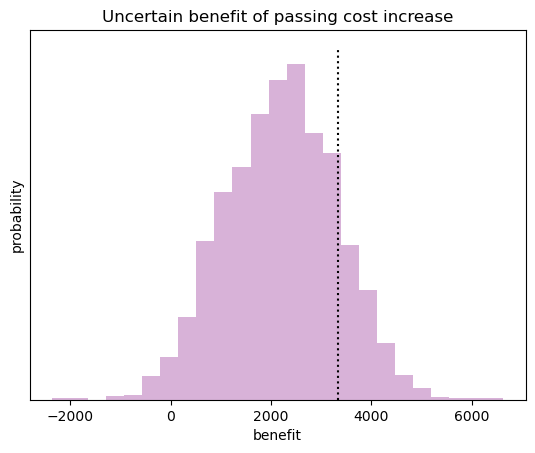

In [54]:
X.the_sample.show_pass_on_cost_delta(70, 30, -10, X.the_true_model);

# Reflections

## The toy model

A mud kitchen is a toy model which doesn't contain all the detail of its real world counterpart. So too is the model explored in this notebook.

In particular, this model has been deliberately designed to be difficult to identify from the supplied data. Suppose we see 1000 sales. Is that 5000 arrivals at our website with a purchase probability of 20%? Or is it 1250 arrivals at 80%? By only supplying sales data, we cannot unpick those two numbers. This concept is known as *parameter unidentifiability*. A similar phenomenon happens when our synthetic data is generated using only one price: how is price sensitivity going to be estimated without observing sales at different prices?

When only considering the MLE approach, this unidentifiability is not obvious from the outputs. An estimate is produced regardless, with no indication of how good it might be. However, we might look again at the posterior distribution of the arrival rate for the uncertain, Bayesian approach. This distribution is typically more spread out than the prior, in the sense of being less peaked. The interpretation of that would be that the data, in combination with the prior, has made us less certain than we were at the start. This is a good thing to know! It is an important indicator that our data is insufficient for identifying the model. 

## Priors and subjectivity in Bayesian analysis

Another important distinction between a Bayesian approach and the MLE approach is the use of *priors*: the quantification of uncertainty upfront, before incorporating any data. This is a subjective judgement call. Used well, this is a strength of the Bayesian approach; used badly, there is the potential to cause significant damage. A key problem is overconfidence. Nothing stops us overasserting ourselves at the start of the analysis, and the Bayesian approach does not immediately identify overconfidence. If we push all of the sliders representing uncertainty to the left, we are saying that we are very confident about the parameter values&mdash;even though we are wrong. This confidence tends to override the contradictory information provided by the small amount of data used in this toy example.

The design of priors is extremely important to powerful uncertainty quantification methods. Well-designed, open-minded but accurate priors can overcome the parameter unidentifiability problem by incorporating expertise and tacit knowledge where data is lacking. However, when designed badly, they can lead to severely suboptimal, overconfident recommendations. Prior design is one aspect of Bayesian analysis where close collaboration between data scientists and domain experts is absolutely vital.

## The super-deluxe toy model

There is some passivity in going from our first figure, where the parameters were set, to the subsequent discussion of learning 'true' parameters. The real world is somewhere in-between. We might well have some real parameters, but other decisions we take can affect these. External marketing, website copy, an improved product (a *super*-deluxe mud kitchen!) can all affect these parameters. However, measuring these effects can only be done in the context of quantified uncertainty. Different customer types (parents vs grandparents, for example) may well have quite different arrival rates at our website, reference prices and price sensitivities, but to what extent? What data do we need for these to be identifiable? Are they different enough that we can detect them in the context of uncertainty? And of course time plays an important role. How does the market for a fun outdoor toy change near Christmas? Uncertainty pervades all of these questions.